# End To End Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file using Runway v0.9.0

In [1]:
import os

import pandas as pd
from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, PyIngest, UserInput
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils import test_database_connection

load_dotenv()

True

## Load and Describe Data

The USER_GENERATED_INPUT variable contains a general discription and feature descriptions for each feature we'd like to use in our graph.

In [2]:
USER_GENERATED_INPUT = UserInput(general_description='This is data on different countries.',
                                 column_descriptions={
                                     'id': 'unique id for a country.',
                                    'name': 'the country name.',
                                    'phone_code': 'country area code.',
                                    'capital': 'the capital of the country.',
                                    'currency_name': "name of the country's currency.",
                                    'region': 'primary region of the country.',
                                    'subregion': 'subregion location of the country.',
                                    'timezones': 'timezones contained within the country borders.',
                                    'latitude': 'the latitude coordinate of the country center.',
                                    'longitude': 'the longitude coordinate of the country center.'
                                    },
                                use_cases=[
        "Which region contains the most subregions?", 
        "What currencies are most popular?", 
        "Which countries share timezones?"
    ]  
                                )

In [3]:
data = pd.read_csv("data/csv/countries.csv")

In [4]:
data.head()

,id,name,iso3,iso2,numeric_code,phone_code,capital,currency,currency_name,currency_symbol,tld,native,region,subregion,timezones,latitude,longitude,emoji,emojiU
0,1,Afghanistan,AFG,AF,4,93,Kabul,AFN,Afghan afghani,؋,.af,افغانستان,Asia,Southern Asia,"[{zoneName:'Asia\/Kabul',gmtOffset:16200,gmtOf...",33.000000,65.0,🇦🇫,U+1F1E6 U+1F1EB
1,2,Aland Islands,ALA,AX,248,+358-18,Mariehamn,EUR,Euro,€,.ax,Åland,Europe,Northern Europe,"[{zoneName:'Europe\/Mariehamn',gmtOffset:7200,...",60.116667,19.9,🇦🇽,U+1F1E6 U+1F1FD
2,3,Albania,ALB,AL,8,355,Tirana,ALL,Albanian lek,Lek,.al,Shqipëria,Europe,Southern Europe,"[{zoneName:'Europe\/Tirane',gmtOffset:3600,gmt...",41.000000,20.0,🇦🇱,U+1F1E6 U+1F1F1
3,4,Algeria,DZA,DZ,12,213,Algiers,DZD,Algerian dinar,دج,.dz,الجزائر,Africa,Northern Africa,"[{zoneName:'Africa\/Algiers',gmtOffset:3600,gm...",28.000000,3.0,🇩🇿,U+1F1E9 U+1F1FF
4,5,American Samoa,ASM,AS,16,+1-684,Pago Pago,USD,US Dollar,$,.as,American Samoa,Oceania,Polynesia,"[{zoneName:'Pacific\/Pago_Pago',gmtOffset:-396...",-14.333333,-170.0,🇦🇸,U+1F1E6 U+1F1F8


## Initialize LLMs

We now initialize the LLMs to use in data discovery and data model creation.

In [5]:
llm_disc = OpenAIDiscoveryLLM(model_name='gpt-4o-2024-05-13', model_params={"temperature": 0})
llm_dm = OpenAIDataModelingLLM(model_name='gpt-4o-2024-05-13', model_params={"temperature": 0.5})

## Discovery

We now load the above data into a Discovery object.

In [6]:
disc = Discovery(llm=llm_disc, user_input=USER_GENERATED_INPUT, data=data)

In [7]:
disc.run(show_result=True, notebook=True)

### Preliminary Analysis of Country Data

#### Overall Details

1. **Data Completeness**:
   - The dataset contains 250 entries with 10 features.
   - Most features are complete, but there are some missing values:
     - `capital`: 5 missing values
     - `region`: 2 missing values
     - `subregion`: 3 missing values

2. **Data Types**:
   - `id`: Integer
   - `name`, `phone_code`, `capital`, `currency_name`, `region`, `subregion`, `timezones`: String (Object)
   - `latitude`, `longitude`: Float

3. **Unique Values**:
   - `name`: 250 unique values (each country is unique)
   - `phone_code`: 235 unique values (some countries share phone codes)
   - `capital`: 244 unique values (one capital is shared by two countries)
   - `currency_name`: 161 unique values (some currencies are shared by multiple countries)
   - `region`: 6 unique values
   - `subregion`: 22 unique values
   - `timezones`: 245 unique values (some timezones are shared by multiple countries)

#### Use Case Analysis

1. **Which region contains the most subregions?**
   - The `region` and `subregion` columns are crucial for this analysis.
   - We need to count the number of unique subregions within each region.

2. **What currencies are most popular?**
   - The `currency_name` column is essential for this analysis.
   - We need to count the frequency of each currency to determine the most popular ones.

3. **Which countries share timezones?**
   - The `timezones` column is key for this analysis.
   - We need to identify countries that have overlapping timezones.

#### Important Features

1. **Region and Subregion**:
   - These features help in understanding the geographical and political divisions of the countries.
   - They are essential for analyzing the distribution of subregions within regions.

2. **Currency Name**:
   - This feature is important for economic analysis and understanding the monetary systems of different countries.
   - It helps in identifying the most commonly used currencies.

3. **Timezones**:
   - This feature is crucial for understanding the temporal aspects and time-related relationships between countries.
   - It helps in identifying countries that share the same timezones, which can be important for various applications like business operations, travel, and communication.

4. **Capital**:
   - Although not directly related to the use cases, the capital city is an important feature for general knowledge and can be useful in various analyses.

5. **Latitude and Longitude**:
   - These features provide geographical coordinates, which can be useful for spatial analysis and mapping.

#### Summary

- The dataset is relatively complete with a few missing values in the `capital`, `region`, and `subregion` columns.
- The most important features for the given use cases are `region`, `subregion`, `currency_name`, and `timezones`.
- Additional features like `latitude`, `longitude`, and `capital` can provide valuable context and support further analyses.

Next steps would involve:
- Cleaning the data to handle missing values.
- Aggregating and analyzing the data to answer the specific use cases.
- Considering how to represent these relationships in a graph data model for Neo4j.

## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. We don't *need* the discovery information for this step to work, but it provides much better models.

In [8]:
gdm = GraphDataModeler(
    llm=llm_dm,
    discovery=disc
)

We now generate our first pass data model.

In [9]:
gdm.create_initial_model()

validation failed
performing chain of thought process for error fix recommendations...
recieved a valid response


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Region', properties=[Property(name='region', type='str', csv_mapping='region', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Subregion', properties=[Property

In [10]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Region', properties=[Property(name='region', type='str', csv_mapping='region', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Subregion', properties=[Property

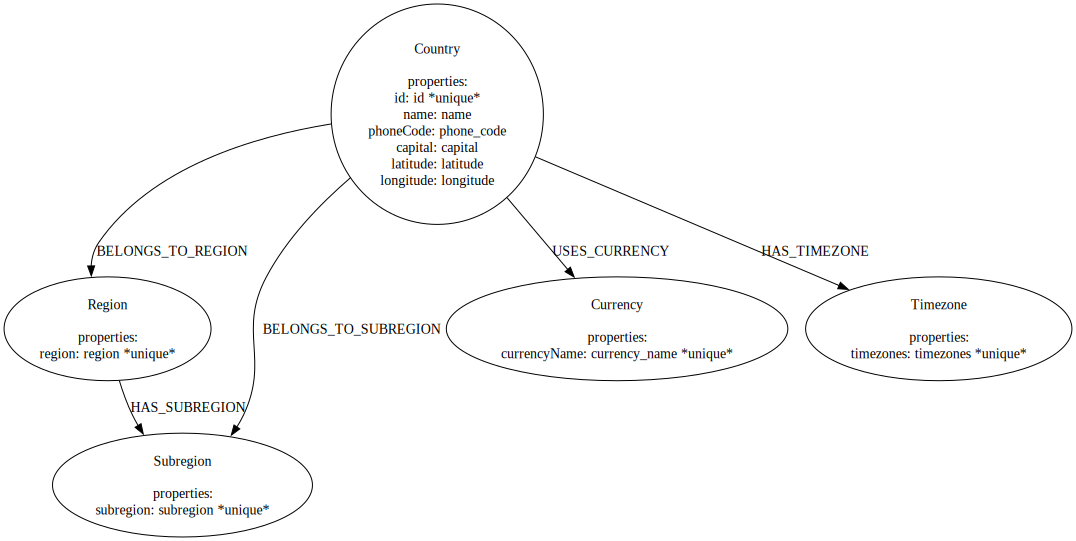

In [11]:
gdm.current_model.visualize()

We can clean this up a bit, so let's prompt the LLM to make some corrections.

In [12]:
gdm.iterate_model(user_corrections="""Remove The relationship between Country and Region.""")

recieved a valid response


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Subregion', properties=[Property(name='subregion', type='str', csv_mapping='subregion', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Currency', properties=[

In [13]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', csv_mapping='phone_code', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Subregion', properties=[Property(name='subregion', type='str', csv_mapping='subregion', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Currency', properties=[

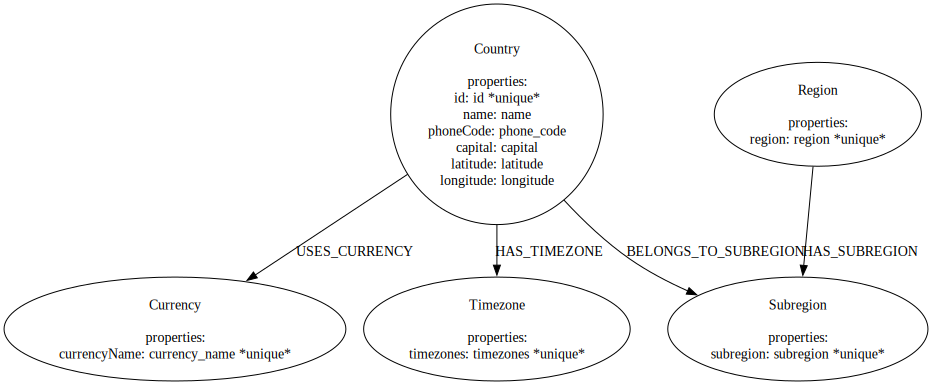

In [14]:
gdm.current_model.visualize()

We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We can provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [15]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         file_directory="data/csv/", csv_name="countries.csv")

In [19]:
pyingest_yaml = gen.generate_config_string()
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT country_id IF NOT EXISTS FOR (n:Country) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT subregion_subregion IF NOT EXISTS FOR (n:Subregion) REQUIRE n.subregion IS UNIQUE;
  - CREATE CONSTRAINT currency_currencyname IF NOT EXISTS FOR (n:Currency) REQUIRE n.currencyName IS UNIQUE;
  - CREATE CONSTRAINT timezone_timezones IF NOT EXISTS FOR (n:Timezone) REQUIRE n.timezones IS UNIQUE;
  - CREATE CONSTRAINT region_region IF NOT EXISTS FOR (n:Region) REQUIRE n.region IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Country {id: toIntegerOrNull(row.id)})
    SET n.name = row.name, n.phoneCode = row.phone_code, n.capital = row.capital, n.latitude = toFloatOrNull(row.latitude), n.longitude = toFloatOrNull(row.longitude)
  url: $BASE/data/csv/countries.csv
- chunk_size: 100
  cql: |
    WITH $dict.rows 

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a modified PyIngest function. First let's confirm our connection though.

In [20]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), "password": os.environ.get("NEO4J_PASSWORD"), "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [22]:
PyIngest(config=pyingest_yaml, dataframe=data)

File {} .//data/csv/countries.csv
loading... 0 2024-08-08 13:30:47.801049
loading... 1 2024-08-08 13:30:47.880631
{} : Completed file 2024-08-08 13:30:47.903632
File {} .//data/csv/countries.csv
loading... 0 2024-08-08 13:30:47.904284
loading... 1 2024-08-08 13:30:47.943986
{} : Completed file 2024-08-08 13:30:47.957237
File {} .//data/csv/countries.csv
loading... 0 2024-08-08 13:30:47.957757
loading... 1 2024-08-08 13:30:47.987587
{} : Completed file 2024-08-08 13:30:48.007453
File {} .//data/csv/countries.csv
loading... 0 2024-08-08 13:30:48.007837
loading... 1 2024-08-08 13:30:48.038595
{} : Completed file 2024-08-08 13:30:48.059046
File {} .//data/csv/countries.csv
loading... 0 2024-08-08 13:30:48.059566
loading... 1 2024-08-08 13:30:48.087154
{} : Completed file 2024-08-08 13:30:48.099672
File {} .//data/csv/countries.csv
loading... 0 2024-08-08 13:30:48.100013
loading... 1 2024-08-08 13:30:48.134636
{} : Completed file 2024-08-08 13:30:48.158952
File {} .//data/csv/countries.csv


If we check our database we can see that we've ingested our CSV according to the data model we've created!

![countries-graph-0.9.0.png](./images/countries-graph-0.9.0.png)